#### Татур А.А.
#### ДЗ 24 - Spark
#### Дата - 26.01.2022
#### Версия - 0.1
#### Задачи
#### Для датасета "winequality-red.csv" провести обработку данных и построить предсказательную модель с использованием функционала pySpark

#### 0. Импорты

In [247]:
import os
import sys

os.environ['PYSPARK_PYTHON'] = 'python'
os.environ['PYSPARK_DRIVER_PYTHON'] = 'jupyter'

In [287]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import count, when, isnan, isnull, desc_nulls_first, desc, \
    from_unixtime, col, dayofweek, dayofyear, hour, to_date, month
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.stat import Correlation

#### 1. Создаем спарк-сессию, загружаем датасет

In [249]:
spark = SparkSession.builder.getOrCreate()

In [250]:
data = spark.read.csv("winequality-red.csv",
                      inferSchema="true", 
                      header="true", 
                      sep =';')

#### 2. Анализ дата-сета

In [251]:
data.printSchema() #знакомимся со схемой дата-сета и представленными колонками. Как видно, в сете нет
                   #категориальных переменных

root
 |-- fixed acidity: double (nullable = true)
 |-- volatile acidity: double (nullable = true)
 |-- citric acid: double (nullable = true)
 |-- residual sugar: double (nullable = true)
 |-- chlorides: double (nullable = true)
 |-- free sulfur dioxide: double (nullable = true)
 |-- total sulfur dioxide: double (nullable = true)
 |-- density: double (nullable = true)
 |-- pH: double (nullable = true)
 |-- sulphates: double (nullable = true)
 |-- alcohol: double (nullable = true)
 |-- quality: integer (nullable = true)



In [252]:
data.show(1, 
          truncate=True, 
          vertical=True) #Выведем 1-ю запись, чтобы посмотреть структуру записи

-RECORD 0----------------------
 fixed acidity        | 7.4    
 volatile acidity     | 0.7    
 citric acid          | 0.0    
 residual sugar       | 1.9    
 chlorides            | 0.076  
 free sulfur dioxide  | 11.0   
 total sulfur dioxide | 34.0   
 density              | 0.9978 
 pH                   | 3.51   
 sulphates            | 0.56   
 alcohol              | 9.4    
 quality              | 5      
only showing top 1 row



In [253]:
data.count() #получаем количество записей

1599

In [259]:
data.count()-data.dropDuplicates().count() #получаем количество дубликатов в сете

240

In [260]:
data = data.dropDuplicates() #удаляем дубликаты

In [261]:
data.count() #количество записей после удаленеия дубликатов

1359

In [263]:
data.select([count(when(isnan(c), c)).alias(c)\
             for c in data.columns]).head().asDict() #Смотрим на количество NaN значений

{'fixed acidity': 0,
 'volatile acidity': 0,
 'citric acid': 0,
 'residual sugar': 0,
 'chlorides': 0,
 'free sulfur dioxide': 0,
 'total sulfur dioxide': 0,
 'density': 0,
 'pH': 0,
 'sulphates': 0,
 'alcohol': 0,
 'quality': 0}

#### 3. Строим графики

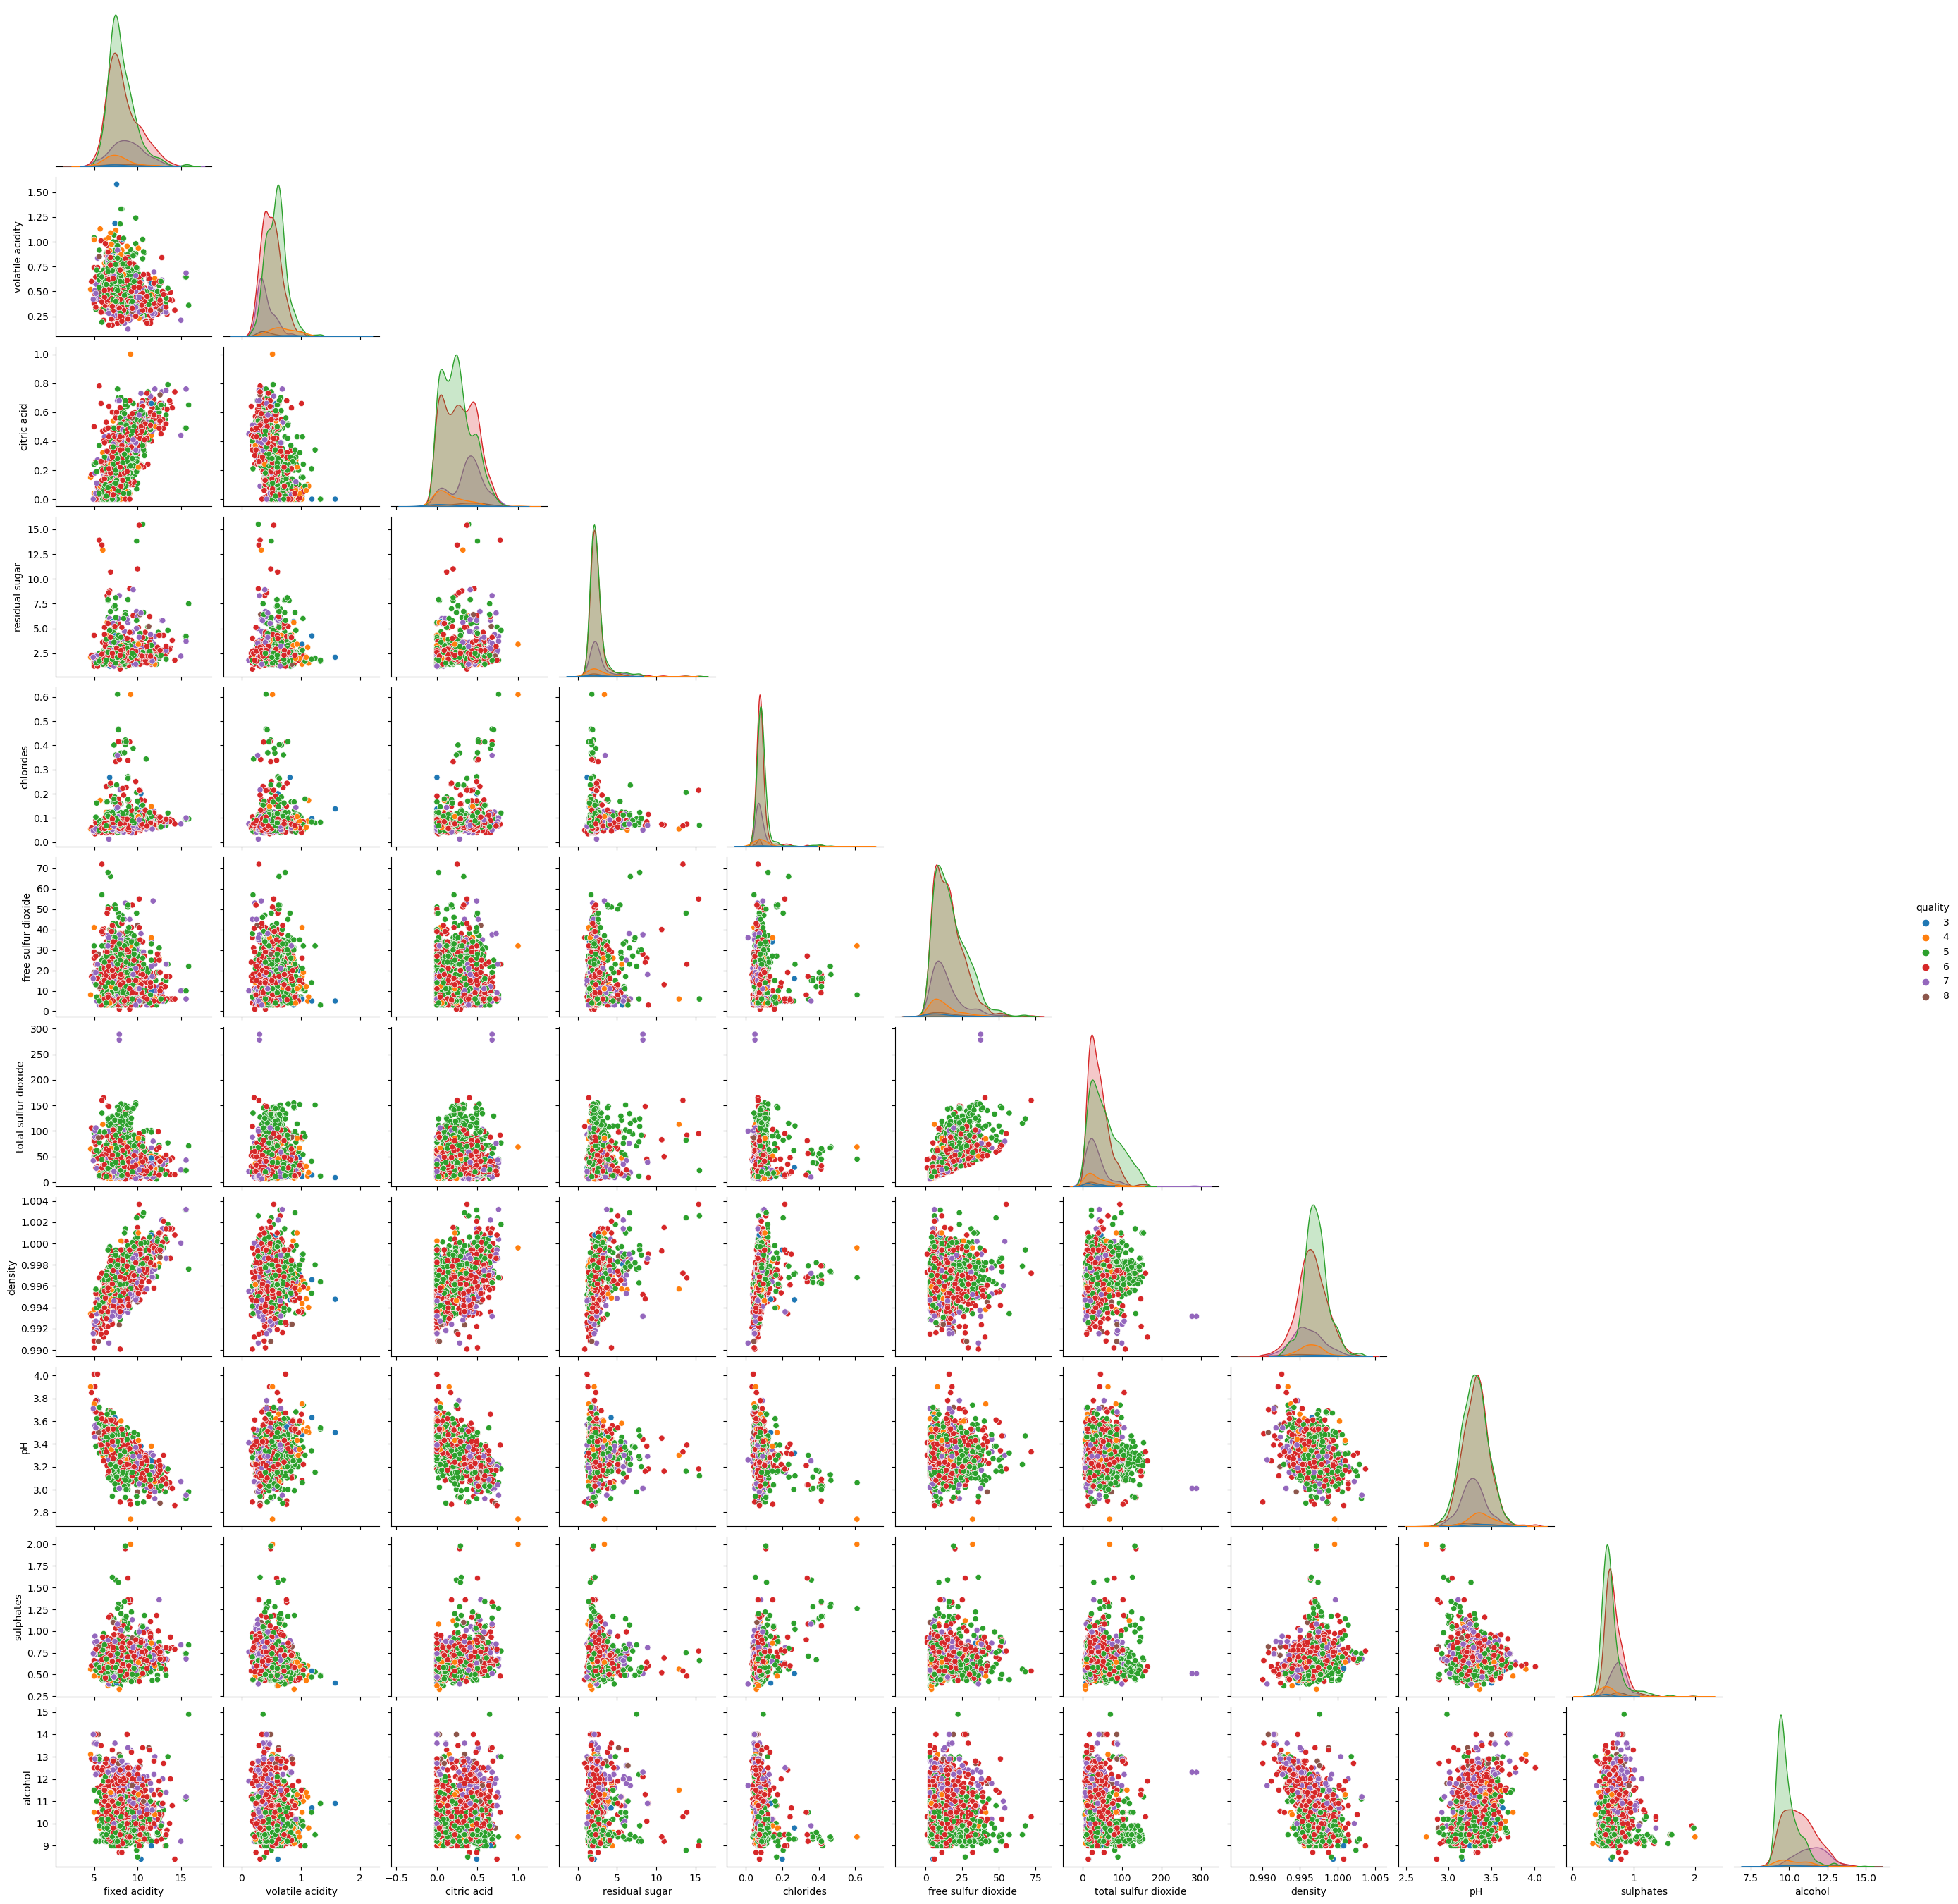

In [264]:
sns.pairplot(data.toPandas(),
            corner=True,
            hue='quality',
            palette='tab10')

In [296]:
assembler = VectorAssembler(inputCols=data.columns, outputCol="corr_features")
df_vector = assembler.transform(data).select("corr_features")

In [300]:
matrix = Correlation.corr(df_vector, "corr_features")
cor_np = matrix.collect()[0][matrix.columns[0]].toArray()

<AxesSubplot: >

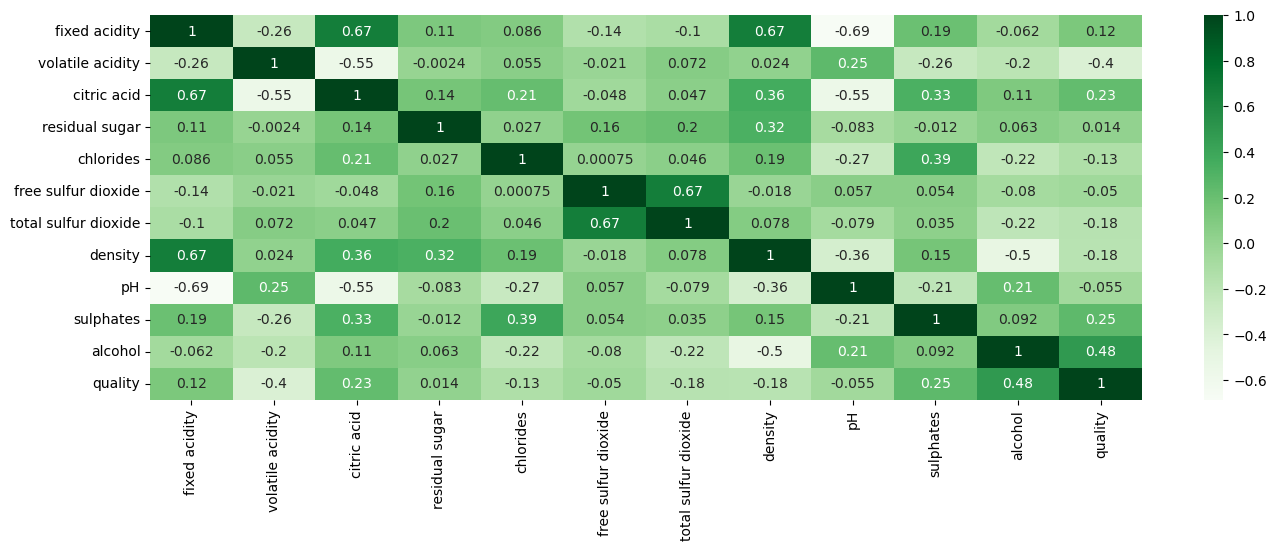

In [302]:
import seaborn as sns 
import matplotlib.pyplot as plt

plt.figure(figsize=(16,5))  
sns.heatmap(cor_np, 
            xticklabels=data.columns,
            yticklabels=data.columns,  
            cmap="Greens", 
            annot=True)

#### 4. Подготавливаем данные для ML модели

In [266]:
stages = []
label_stringIdx = StringIndexer(inputCol = 'quality', outputCol = 'label') #Кодируем целевую колонку
stages += [label_stringIdx]
numericCols = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides',
               'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH','sulphates',
               'alcohol']
assemblerInputs = numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="Subscribed") #Кодируем features
stages += [assembler]

In [268]:
pipeline = Pipeline(stages = stages) #Создаем преплайн
pipelineModel = pipeline.fit(data)
df = pipelineModel.transform(data)
selectedCols = ['label', 'Subscribed'] + numericCols
df = df.select(selectedCols)
df.printSchema() #Выводим схему полученной таблицы. В ней появились две новые колонки label и Subscribed

root
 |-- label: double (nullable = false)
 |-- Subscribed: vector (nullable = true)
 |-- fixed acidity: double (nullable = true)
 |-- volatile acidity: double (nullable = true)
 |-- citric acid: double (nullable = true)
 |-- residual sugar: double (nullable = true)
 |-- chlorides: double (nullable = true)
 |-- free sulfur dioxide: double (nullable = true)
 |-- total sulfur dioxide: double (nullable = true)
 |-- density: double (nullable = true)
 |-- pH: double (nullable = true)
 |-- sulphates: double (nullable = true)
 |-- alcohol: double (nullable = true)



In [269]:
df.select('label', 'Subscribed').show(10)

+-----+--------------------+
|label|          Subscribed|
+-----+--------------------+
|  3.0|[9.9,0.5,0.24,2.3...|
|  0.0|[7.9,0.72,0.01,1....|
|  2.0|[8.3,0.3,0.49,3.8...|
|  2.0|[10.2,0.34,0.48,2...|
|  1.0|[7.7,0.57,0.21,1....|
|  0.0|[7.5,0.61,0.2,1.7...|
|  0.0|[6.4,0.4,0.23,1.6...|
|  2.0|[12.0,0.37,0.76,4...|
|  0.0|[7.2,0.54,0.27,2....|
|  1.0|[7.2,0.53,0.14,2....|
+-----+--------------------+
only showing top 10 rows



#### 5. Разбиваем выборку на тренировочный и тестировочный сеты

In [274]:
train, test = df.randomSplit([0.8, 0.2], seed = 80)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 1096
Test Dataset Count: 263


In [275]:
train.groupBy('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|  0.0|  465|
|  1.0|  427|
|  4.0|   16|
|  3.0|   48|
|  2.0|  131|
|  5.0|    9|
+-----+-----+



In [276]:
test.groupBy('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|  0.0|  112|
|  1.0|  108|
|  4.0|    1|
|  3.0|    5|
|  2.0|   36|
|  5.0|    1|
+-----+-----+



In [277]:
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(featuresCol = 'Subscribed', labelCol = 'label')
rfModel = rf.fit(train)
predictions = rfModel.transform(test)

In [278]:
predictions.filter((col('label') == 0.0)).select('label', 'prediction').show()

+-----+----------+
|label|prediction|
+-----+----------+
|  0.0|       1.0|
|  0.0|       0.0|
|  0.0|       1.0|
|  0.0|       1.0|
|  0.0|       1.0|
|  0.0|       1.0|
|  0.0|       1.0|
|  0.0|       1.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       1.0|
|  0.0|       0.0|
|  0.0|       1.0|
|  0.0|       0.0|
|  0.0|       1.0|
|  0.0|       0.0|
|  0.0|       1.0|
|  0.0|       0.0|
+-----+----------+
only showing top 20 rows



In [279]:
predictions.filter((col('label') == 1.0)).select('label', 'prediction').show()

+-----+----------+
|label|prediction|
+-----+----------+
|  1.0|       0.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       0.0|
|  1.0|       2.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       0.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       0.0|
|  1.0|       1.0|
|  1.0|       0.0|
|  1.0|       1.0|
+-----+----------+
only showing top 20 rows



In [280]:
predictions.filter((col('label') == 2.0)).select('label', 'prediction').show()

+-----+----------+
|label|prediction|
+-----+----------+
|  2.0|       1.0|
|  2.0|       1.0|
|  2.0|       1.0|
|  2.0|       2.0|
|  2.0|       1.0|
|  2.0|       1.0|
|  2.0|       2.0|
|  2.0|       1.0|
|  2.0|       2.0|
|  2.0|       1.0|
|  2.0|       1.0|
|  2.0|       1.0|
|  2.0|       0.0|
|  2.0|       0.0|
|  2.0|       1.0|
|  2.0|       2.0|
|  2.0|       2.0|
|  2.0|       1.0|
|  2.0|       2.0|
|  2.0|       0.0|
+-----+----------+
only showing top 20 rows



In [281]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(metricName="weightedFMeasure")
print('Weighted F-Measure', evaluator.evaluate(predictions))

Weighted F-Measure 0.5607980247865961
